# Repetition Suppression

In [1]:
import nibabel as nib
from nipype.interfaces import fsl
from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import matplotlib.pyplot as plt
from collections import OrderedDict

In [28]:
%matplotlib inline

In [3]:
# import custom libraries
from tools.glm import (add_regressors, array2dummies,
                       n_back_array, n_back_series,
                       glm, contrast)
from tools.parametric import (exp_decay, repeat, iter_model,
                              diff_model, decay_model, 
                              martini_decay)

In [4]:
root = "../"

In [5]:
search_data = os.path.join(root, "data", "search")
stairs_data = os.path.join(root, "data", "stairs")
print("Path to search data %s." % os.path.abspath(search_data))
print("Path to stairs data %s." % os.path.abspath(stairs_data))

Path to search data /data/ext_data/PhD/Studies/PrimingDecay/data/search.
Path to stairs data /data/ext_data/PhD/Studies/PrimingDecay/data/stairs.


## Load search data

In [6]:
# sessions per subject.
subjects = [1,2,3,4,5,6]
sessions = {1: [2,3,4,5],
            2: [2,3],
            3: [1,2,3,4],
            4: [1,2,3],
            5: [1,2,4,5],
            6: [1,2]}

In [7]:
# import data of all subjects into single 
# pandas dataframe. Store also the subject
# number, session number and scan number.
block = 0
data = pd.DataFrame()
for sub in subjects:
    real_ses = 0
    for ses in sessions[sub]:
        for scn in range(12):
            fname = "sub_%03d_ses_%03d_scn_%03d.txt"
            path = os.path.join(search_data, fname % (sub, ses, scn))
            # Try to load 12 scans. Continue of load fails,
            # because there are not 12 scans for each session.
            try:
                df = pd.read_csv(path, 
                                 names=["tr_nr", "isi", "cum_isi",
                                        "cut_loc", "tgt_loc", "tgt_clr", "dis_clr",
                                        "stim_onset", "stim_offset", 
                                        "trigger", "rt"],
                                 delimiter="\t")
                
                # Update dataframe.
                df["block"] = block
                block += 1
                df["sub"] = sub
                df["ses"] = ses
                df["scn"] = scn
                df["real_ses"] = real_ses             
                data = data.append(df)
                
            except:
#                 print("%s does not exist." % path)
                pass
        
        # Update session number
        real_ses += 1

In [8]:
data.head()

,tr_nr,isi,cum_isi,cut_loc,tgt_loc,tgt_clr,dis_clr,stim_onset,stim_offset,trigger,rt,block,sub,ses,scn,real_ses
0,0,5.5,5.5,1,0,1,0,5790.575809,5790.794762,1,5784.990589,0,1,2,0,0
1,0,5.5,5.5,1,0,1,0,5790.575809,5790.794762,1,5787.091428,0,1,2,0,0
2,0,5.5,5.5,1,0,1,0,5790.575809,5790.794762,1,5789.190371,0,1,2,0,0
3,0,5.5,5.5,1,0,1,0,5790.575809,5790.794762,1,5791.291413,0,1,2,0,0
4,0,5.5,5.5,1,0,1,0,5790.575809,5790.794762,A,5791.531344,0,1,2,0,0


In [9]:
data.groupby(["sub", "ses", "scn"]).tr_nr.count().groupby(["sub", "ses"]).count().groupby(["sub"]).count()

sub
1    4
2    2
3    4
4    3
5    4
6    2
Name: tr_nr, dtype: int64

## Preprocessing search data

In [10]:
# Subtract baseline (time at first trigger)
data = data.assign(bl_onset=data.stim_onset)
data = data.assign(bl_offset=data.stim_offset)
baseline = data.groupby(["sub", "ses", "scn"]).rt.first()
idx = data.set_index(["sub", "ses", "scn"]).index

# Response times
bl_rt = data.set_index(["sub", "ses", "scn"]).rt - baseline[idx]
data = data.assign(bl_rt=bl_rt.values)

# Stimulus onsets
bl_onset = data.set_index(["sub", "ses", "scn"]).stim_onset - baseline[idx]
data = data.assign(bl_onset=bl_onset.values)

# Stimulus offsets
bl_offset = data.set_index(["sub", "ses", "scn"]).stim_offset - baseline[idx]
data = data.assign(bl_offset=bl_offset.values)

In [11]:
# Exclude rows without TR trigger. We 
# derive the trial sequence from the
# rows with TR trigger (because not all 
# trials have a response).
trig = data[data.trigger == "1"]
trial = data.groupby(["sub", "real_ses", "scn", "tr_nr"]).first()

In [12]:
# Exclude rows with tr trigger
resp = data[data.trigger != "1"]

# Response times relative to stimulus onset.
real_rt = resp.bl_rt - resp.bl_onset
resp = resp.assign(real_rt=real_rt)

# Excluded missed responses (RT = -1)
resp = resp[resp.rt >= 0]

# exclude Invalid rows (real RT < 0)
resp = resp[resp.real_rt > 0]

# Consider RTs > 2 and < .2 as outliers.
outliers = (resp.real_rt < .2) | (resp.real_rt > 2)
resp = resp.assign(outlier=outliers)

# Keep first trials
resp = resp.groupby(["sub", "real_ses", "scn", "tr_nr"]).first()

In [13]:
resp = resp.assign(detrended_rt=None)
for (sub, ses, scn), group in resp.groupby(["sub", "real_ses", "scn"]):
    
    x = group[~group.outlier].index.get_level_values("tr_nr")
    y = group[~group.outlier].real_rt
    
    # detrend excluding outliers
    # For some reason, these arrays aren't numeric?
    # So make numeric to be able to do linear regression.
    a,b,_,_,_ = stats.linregress(pd.to_numeric(x), pd.to_numeric(y))
    
    # Subtract only the slope from data.
    detrended = group.real_rt - (group.index.get_level_values("tr_nr") * a)
    resp.loc[(sub, ses, scn), "detrended_rt"] = detrended
    
    m = detrended.mean()
    sd = detrended.std()
    resp.loc[(sub, ses, scn), "norm_rt"] = ((detrended - m) / sd)

# Normalize to grand mean.
norm_rt = (resp.norm_rt * 
           resp.detrended_rt[~resp.outlier].std() + 
           resp.detrended_rt[~resp.outlier].mean())
resp = resp.assign(norm_rt=norm_rt) 

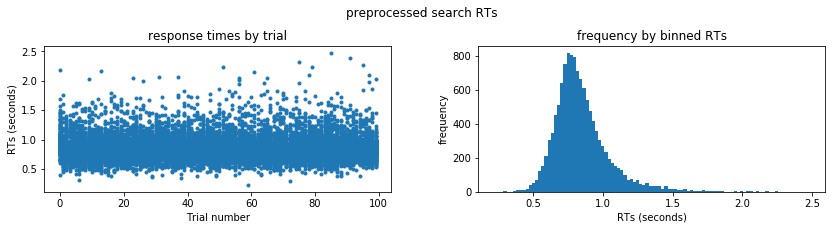

In [14]:
x = resp[~resp.outlier].index.get_level_values("tr_nr")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 3))
fig.suptitle("preprocessed search RTs")

ax1.plot(x, resp.norm_rt[~resp.outlier], ".")
ax1.set_title("response times by trial")
ax1.set_ylabel("RTs (seconds)")
ax1.set_xlabel("Trial number")

ax2.hist(resp.norm_rt[~resp.outlier], bins=100)
ax2.set_title("frequency by binned RTs")
ax2.set_ylabel("frequency")
ax2.set_xlabel("RTs (seconds)")

fig.subplots_adjust(top=.8, wspace=.25)

Text(0,0.5,'Normalized RTs')

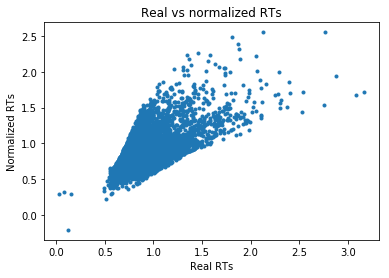

In [15]:
fig, ax = plt.subplots()
ax.plot(resp.real_rt, resp.norm_rt, ".")
ax.set_title("Real vs normalized RTs")
ax.set_xlabel("Real RTs")
ax.set_ylabel("Normalized RTs")

## GLM

Values are normalized per scan, by subtracting the mean and dividing by the standard deviation. To get back to a more familiar scale, values per scan are then multiplied by the grand standard deviation and added to the grand mean).

We can now fit a glm to each dataset per subject and average across scans, assuming that decay rates per subject are fixed, and assuming that decay rates across subjects are varying.

We can fit an exponential function to the parameter estimates to estimate the decay of search facilitation across trials. We do so by first averaging across scans, and fitting the kernel to the mean twenty parameter estimates.

For comparison, we also fit the kernel to the whole dataset of each participant. This should not make a big difference, if any.

In [16]:
# regression
n_back = 12
Ms = pd.DataFrame()
for (sub, ses, scn), group in resp.groupby(["sub", "real_ses", "scn"]):
    
    trials = trial.loc[(sub, ses, scn), :]

    tgt_loc = n_back_series(trials.tgt_loc.values, n_back)
    tgt_clr = n_back_series(trials.tgt_clr.values, n_back)

    # create design matrix from data
    M = np.ones(len(trials))
    M = add_regressors(M, tgt_loc)
    M = add_regressors(M, tgt_clr)
    
    M = pd.DataFrame(M.T)
    M.index.name = "tr_nr"
    M = M.reset_index("tr_nr").assign(**{
        "sub": sub,
        "real_ses": ses,
        "scn": scn
    }).set_index(["sub", "real_ses", "scn", "tr_nr"])
        
    Ms = Ms.append(M, ignore_index=False)


old_cols = list(range(41))
new_cols = ["icept"] + ["loc_lag_%d" % i for i in range(1, n_back+1)] + ["clr_lag_%d" % i for i in range(1, n_back+1)]
cols = {k:v for k, v in zip(old_cols, new_cols)}

Ms = (
    Ms
    .rename(columns=cols)
    .loc[:, new_cols]
)

to_R = Ms.join(resp.norm_rt).reset_index()

## Convert data to R and apply lm to get std error

In [17]:
%load_ext rpy2.ipython

/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: package ‘methods’ was built under R version 3.4.3 

  warnings.warn(x, RRuntimeWarning)
/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: package ‘datasets’ was built under R version 3.4.3 

  warnings.warn(x, RRuntimeWarning)
/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: package ‘utils’ was built under R version 3.4.3 

  wa

In [18]:
%%R -i to_R -o out

out <- data.frame()

for(i in 1:6) {
    # Load the df of subject 1
    subj      <- to_R[to_R$sub == i , ]

    # Drop the session info from data
    drop      <- c("sub", "real_ses", "scn", "tr_nr")
    meta_info <- subj[ , drop]
    data      <- subj[ , !(names(subj) %in% drop)]
    mr        <- lm(norm_rt ~ ., data=data)
    df        <- data.frame(summary(mr)$coeff)

    # Make pretty before export
    df           <- cbind(df, rownames(df), row.names=NULL)
    colnames(df) <- c("est", "std_err", "tval", "pval", "name")
    
    df[ "sub" ]  <- meta_info[ "sub" ]    
    out <- rbind( out, df )
}

/opt/conda/envs/neuro/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Creating priming-levelmodels, based on decay kernels

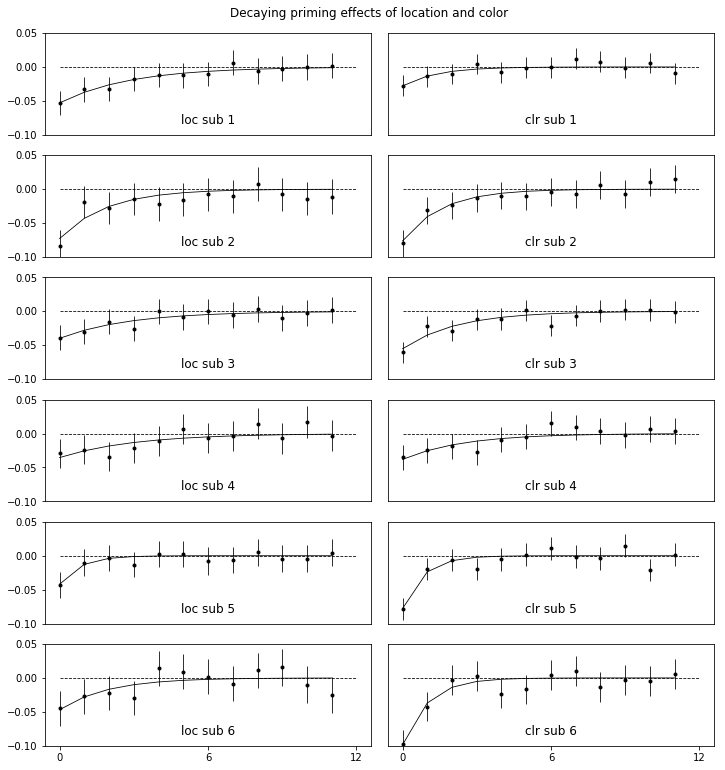

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(12,12))
fits = pd.DataFrame()

for sub, group in out.groupby("sub"):
    
    row = int(sub) - 1
    ax1 = axes[row][0]
    ax2 = axes[row][1]
    x = range(n_back)
    
    # Locs
    bloc = group.name.str.contains("loc")
    bclr = group.name.str.contains("clr")
    
    # estimates, and conf. intervals
    y1 = group[bloc].est
    y1_err = group[bloc].std_err * 1.96
        
    y2 = group[bclr].est
    y2_err = group[bclr].std_err * 1.96
    
    # Fit exp curve
    (lw, lt), _ = curve_fit(exp_decay, x, y1, p0=[1, 1.5])
    (cw, ct), _ = curve_fit(exp_decay, x, y2, p0=[1, 1.5])
    
    fit = pd.DataFrame({
        "sub": sub,
        "lt": [lt],
        "lw": [lw], 
        "ct": [ct],
        "cw": [cw],
    })
    
    fits = fits.append(fit.set_index("sub"))
    
    # Plot 
    ax1.hlines(0, 0, n_back, color="k", linestyle="--", linewidth=.8)
    ax1.errorbar(x, y1, yerr=y1_err, fmt="k.", linewidth=.8)
    ax1.plot(x, exp_decay(x, lw, lt), "k-", linewidth=.8)
    ax1.set_ylim(-0.1, 0.05)
    ax1.set_title("loc sub %d" % sub, y=.05, x=.5)

    ax2.hlines(0, 0, n_back, color="k", linestyle="--", linewidth=.8)
    ax2.errorbar(x, y2, yerr=y2_err, fmt="k.", linewidth=.8)
    ax2.plot(x, exp_decay(x, cw, ct), "k-", linewidth=.8)
    ax2.set_ylim(-0.1, 0.05)
    ax2.set_yticks([])
    ax2.set_title("clr sub %d" % sub, y=.05, x=.5)

    if row == 5:
        ax1.set_xticks([0, n_back/2, n_back])
        ax2.set_xticks([0, n_back/2, n_back])
    else:
        ax1.set_xticks([])
        ax2.set_xticks([])

fig.suptitle("Decaying priming effects of location and color")
fig.subplots_adjust(hspace=.2, wspace=.05, top=.95)    

In [20]:
fits = fits.assign(**{
    "a": None,
    "b": None,
    "r": None
})

for j, (idx, group) in enumerate(trial.groupby(["sub", "real_ses", "scn"])):
    # unpack index
    sub, ses, scn = idx
    
    # Create dummies for target color and location
    # We'll use this to calculate a "priming-level"
    # per location, as well as an overall priming level.
    # It might come in handy to havbe a priming level
    # per location, if we want to look at BOLD-effects
    # retinotopically.
    tgt_clr = group.tgt_clr.values
    tgt_loc = group.tgt_loc.values
    locs = array2dummies(tgt_loc)
    clrs = array2dummies(tgt_clr)

    # Here we calculate the level of priming
    # per color. Having two (target) colors alternating
    # the levels of priming for both colors are
    # opposites (i.e. *-1).    
    clr_priming = []
    ct = fits.loc[sub, "ct"]
    for i, clr in enumerate(clrs):
        model = diff_model(clr, t=ct, y0=.5, c=1)
        clr_priming.append( np.array(model) )

    # Now we have the priming level, determine
    # the level of priming per display item.
    # First, for each location determine the
    # color of the display item:
    # location = 1 & color = 1 -> item color = 1
    # location = 1 & color = 0 -> item color = 0
    # location = 0 & color = 1 -> item color = 0
    # location = 0 & color = 0 -> item color = 1
    items = (locs == tgt_clr).astype(int)
    clr_priming_item = []
    # Then, for each item ...
    for i, item in enumerate(items):
        priming = np.zeros(len(item))
        # if item color = 0, then get priming 
        # level to color 0, 
        # if item color = 1, then get priming 
        # level to color 1.
        priming[item==0] = clr_priming[0][item==0]
        priming[item==1] = clr_priming[1][item==1]
        
        # Giving four rows with priming levels
        # to each item.
        clr_priming_item.append(priming)

    # To determine the general priming level,
    # multiply by location and sum the four rows.
    # This gets us to the same result of just 
    # calculating the priming level per trial,
    # by calculating priming level by color repition
    # given target color at a certain trial.
    priming_sum = np.sum(clr_priming_item*locs, axis=0)
    
    # We then rescale the whole thing, so that lag-1
    # repetition, priming level has a value of 1,
    # for each participant, each session, etc.
    priming_sum /= (1 - np.exp(-fits.loc[sub, "ct"]))
    
    # Now determine lag-1 priming level (0 for switch,
    # 1 for repetition).
    lag1_clr = n_back_array(group.tgt_clr, 1)
    
    # We start ambivalent, so no priming = 0.5.
    # this is important otherwise we'll get a dip at 
    # 0 for all our regressors, so it will capture the 
    # bold response related to onset of the experiment.
    lag1_clr[0] = .5
    
    # To look at the independent contribution of lag-2+ priming 
    # subtract the lag-1 level from the general summed priming level.
    lag2_clr = priming_sum - lag1_clr

    # Now, do the same thing for location priming.
    # That's a bit convoluted -- location priming per location,
    # but technically we'll end up with the same thing anyway:
    # general priming level, now for location.
    # We'll just ignore the location priming level
    # per location for now as it seems meaningless,
    # although difficult to wrap your head around.
    loc_priming = []
    lt = fits.loc[sub, "lt"]
    # For each location ...
    for i, loc in enumerate(locs):
        # Setup a model for that location,
        # given target repetition at that location.
        model = diff_model(loc, t=lt, y0=.25, c=1)
        loc_priming.append(np.array(model))

    # Sum the whole thing
    priming_sum = np.sum(loc_priming*locs, axis=0)
    # Scale, so that 1 location repetition, corresponds
    # to priming level of 1.
    priming_sum /= (1 - np.exp(-fits.loc[sub, "lt"]))
    
    # Lag-1 priming level (0, 1), starts with 0.25
    # (i.e. primed equally to each 4 items)
    lag1_loc = n_back_array(group.tgt_loc, 1)
    lag1_loc[0] = .25
    
    # Subtract lag-1 priming to get lag-2+ priming level.
    lag2_loc = priming_sum - lag1_loc

    # Cool, so we have our basic regressors now.
    # Let's store them.
    trial.loc[idx, "lag1_clr"] = lag1_clr
    trial.loc[idx, "lag2_clr"] = lag2_clr
    trial.loc[idx, "lag1_loc"] = lag1_loc
    trial.loc[idx, "lag2_loc"] = lag2_loc

    # We can also check how well our model predicts response times.
    rt = resp.loc[idx, "norm_rt"]
    predicted = (lag1_clr + lag1_loc + lag2_clr + lag2_loc)[rt.index]

    a, b, r, _, _ = stats.linregress(predicted[~resp.loc[idx, "outlier"]], 
                                     rt[~resp.loc[idx, "outlier"]])

    fits.loc[sub, ["a", "b", "r"]] = (a, b, r)
    
    tr_nr = resp.loc[idx].index.get_level_values("tr_nr")
    resp.loc[idx, "lag1_clr"] = lag1_clr[tr_nr]
    resp.loc[idx, "lag2_clr"] = lag2_clr[tr_nr]
    resp.loc[idx, "lag1_loc"] = lag1_loc[tr_nr]
    resp.loc[idx, "lag2_loc"] = lag2_loc[tr_nr]

print("done.")

done.


## Linear relation between modelled response times, and real response times

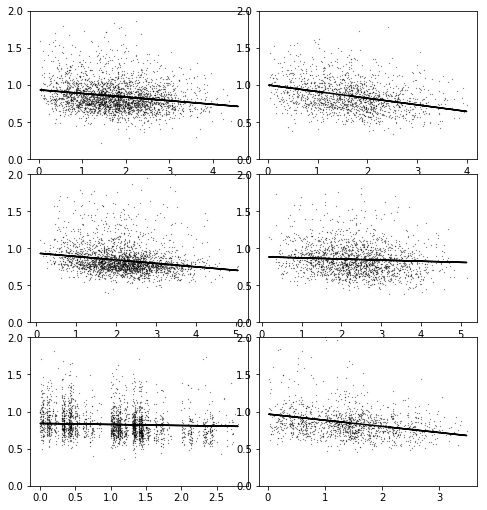

In [21]:
# Color priming
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

for i, (sub, group) in enumerate(trial.groupby("sub")):
    
    # Plot position
    col, row = (i % 2, int(i/2) % 3)
    ax = axes[row][col]

    tr_nr = group.index.get_level_values("tr_nr")
        
    priming_level = resp.loc[sub, ["lag1_clr", "lag2_clr", "lag1_loc", "lag2_loc"]].T.sum()
    a, b = (fits.loc[sub, "a"], fits.loc[sub, "b"])
    rt = resp.loc[sub, "norm_rt"]

    ax.plot(priming_level[~resp.loc[sub, "outlier"]], rt[~resp.loc[sub, "outlier"]], "k.", markersize=.5, alpha=.8)
    ax.plot(priming_level, priming_level * a + b, "k-")
    ax.set_ylim(0, 2)
            
fig.subplots_adjust(hspace=.1, wspace=.05, top=.95)

## Explained variance across scans per subject for each model component.

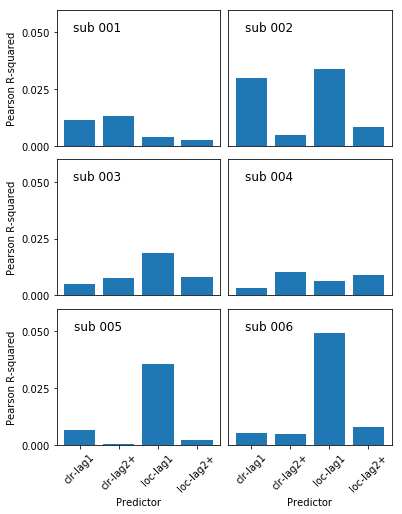

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))
gs = 6
for i, (sub, group) in enumerate(resp.groupby(["sub"])):
    row, col = (int(i/2) % 3, i % 2)
    
    ax = axes[row][col]
    a,b,rc1,_,_ = stats.linregress(group.lag1_clr, group.norm_rt)
    a,b,rc2,_,_ = stats.linregress(group.lag2_clr, group.norm_rt)
    a,b,rl1,_,_ = stats.linregress(group.lag1_loc, group.norm_rt)
    a,b,rl2,_,_ = stats.linregress(group.lag2_loc, group.norm_rt)
    
    ax.bar(range(4), [rl1**2, rl2**2, rc1**2, rc2**2])
    ax.set_title("sub %03d" % sub, y=.8, x=.25)
   
    if col == 0:
        ax.set_yticks([0, 0.025, 0.05])
        ax.set_ylabel("Pearson R-squared")
    else:
        ax.set_yticks([])
            
    if row == 2:
        ax.set_xticks(range(4))
        ax.set_xticklabels(["clr-lag1", "clr-lag2+", "loc-lag1", "loc-lag2+"], rotation=45)
        ax.set_xlabel("Predictor")
    else:
        ax.set_xticks([])
        
    ax.set_ylim(0, 0.06)
        
fig.subplots_adjust(wspace=.05, hspace=.1)

In [ ]:
def decay_final(in_file='',
                params_loc='',
                params_clr='',
                duration=.2,
                baseline=False,
                **kwargs):

    from nipype.interfaces.base import Bunch
    import numpy as np

    # Create event files output
    conditions = ['loc1', 'loc2', 'loc3', 'loc4',
                  'loc_lag1', 'loc_lag2',
                  'clr_lag1', 'clr_lag2']

    onsets = [data['stim_onset']]*len(conditions)
    durations = [[duration]*len(data)]*len(conditions)

    amplitudes = [list(loc) for loc in locs]
    amplitudes += [loc_priming_lag1, loc_priming_lag2,
                   clr_priming_lag1, clr_priming_lag2]

    output = Bunch(conditions=conditions, onsets=onsets,
                   durations=durations, amplitudes=amplitudes)

    return output

In [27]:
prev_scn = -1
for (sub, real_ses, scn), group in trial.groupby(["sub", "real_ses", "scn"]):
    out_dir = os.path.join(nii, "sub_%03d" % sub, "ses_%03d" % real_ses)
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    dst = "run_%03d_clr_lag1.csv" % scn
    dst = "run_%03d_clr_lag2.csv" % scn
    dst = "run_%03d_loc_lag1.csv" % scn
    dst = "run_%03d_loc_lag2.csv" % scn
    group